<a href="https://colab.research.google.com/github/alastra32/DS-Unit-2-Applied-Modeling/blob/master/module4/assignment_applied_modeling_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 4

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make a Shapley force plot to explain at least 1 individual prediction.
- [ ] Share at least 1 visualization on Slack.

(If you haven't completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!


## Links
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

## Setup 

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.1.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

# merge train_features.csv & train_labels.csv
trainandval = pd.merge(pd.read_csv('https://raw.githubusercontent.com/alastra32/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/train_features.csv'), 
                 pd.read_csv('https://raw.githubusercontent.com/alastra32/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/train_labels.csv'))

# read test_features.csv & sample_submission.csv
test = pd.read_csv('https://raw.githubusercontent.com/alastra32/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/test_features.csv')
sample_submission = pd.read_csv('https://raw.githubusercontent.com/alastra32/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/sample_submission.csv')

In [0]:
# import block
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import category_encoders as ce
from xgboost import XGBClassifier

In [4]:
# train validation split
train, val = train_test_split(trainandval, train_size=0.95, test_size=0.05, 
                              stratify=trainandval['status_group'], random_state=42)

train.shape, val.shape, test.shape

((56430, 41), (2970, 41), (14358, 40))

## Manual Mode 



In [0]:
# We need a function that returns the mode of a given series for the imputer function.
def manual_mode(feature):
  try: 
    return feature.mode()[0]
  except:
    pass

## Imputer

In [0]:
# imputes by the lowest non-null region measure


def fill_nulls(df, feature, method):
  #attempt to fill nulls by method in succesively larger geographic scopes
  df = df.copy()# avoid settingwithcopy warning
  geo_scopes = ['ward', 'lga', 'region', 'basin']
  
  if method == 'mode':
    method = manual_mode
  
  for scope in geo_scopes:
    if df[feature].isnull().sum() == 0:
      break
    df[feature] = df[feature].fillna(df.groupby(scope)[feature].transform(method))

  return df[feature]


def impute(df, features, method):
  #imputation of given features by given method (mean/median/mode)
  df = df.copy()
  
  for feature in features:
    df[feature] = fill_nulls(df, feature, method)

  return df

## Wrangler

In [0]:


def flag_missing_values(df):
  '''add "<FEATURE>_MISSING" flag feature for all columns with nulls'''
  df.copy()
  
  columns_with_nulls = df.columns[df.isna().any()]
  
  for col in columns_with_nulls:
    df[col+'_MISSING'] = df[col].isna()
  
  return df


def convert_dummy_nulls(df):
  '''Convert 0 to NaN's'''
  df = df.copy()
  
  # replace near-zero latitudes with zero
  df['latitude'] = df['latitude'].replace(-2e-08, 0)
  
  zero_columns = ['longitude', 'latitude', 'construction_year', 'gps_height', 
                  'population']
  
  for col in zero_columns:
    df[col] = df[col].replace(0, np.nan)
    
  return df
  
    
def clean_text_columns(df):
  '''convert text to lowercase, remove non-alphanumerics, unknowns to NaN'''
  df = df.copy()
  
  text_columns = df[df.columns[(df.applymap(type) == str).all(0)]]
  unknowns = ['unknown', 'notknown', 'none', 'nan', '']
    
  for col in text_columns:
    df[col] = df[col].str.lower().str.replace('\W', '')
    df[col] = df[col].replace(unknowns, np.nan)

  return df


def get_distances_to_population_centers(df):
  '''create a distance feature for population centers'''
  df = df.copy()
  population_centers = {'dar': (6.7924, 39.2083), 
                        'mwanza': (2.5164, 32.9175),
                        'dodoma': (6.1630, 35.7516)}
  
  for city, loc in population_centers.items():
    df[city+'_distance'] = ((((df['latitude']-loc[0])**2)
                           + ((df['longitude']-loc[1])**2))**0.5)
  
  return df


def engineer_date_features(df):
  df = df.copy()
  
  # change date_recorded to datetime format
  df['date_recorded'] = pd.to_datetime(df.date_recorded, 
                                      infer_datetime_format=True)
    
  # extract components from date_recorded
  df['year_recorded'] = df['date_recorded'].dt.year
  df['month_recorded'] = df['date_recorded'].dt.month
  df['day_recorded'] = df['date_recorded'].dt.day

  df['inspection_interval'] = df['year_recorded'] - df['construction_year']
  
  return df


def wrangle(df):
    '''cleaning/engineering function'''
    df = df.copy()
    
    df = convert_dummy_nulls(df)   
    df = clean_text_columns(df)
    df = get_distances_to_population_centers(df)
    df = engineer_date_features(df)
    df = flag_missing_values(df)
    
    drop_features = ['recorded_by', 'id', 'date_recorded']
    df = df.drop(columns=drop_features)

    # Apply imputation
    numeric_columns = df.select_dtypes(include = 'number').columns
    nonnumeric_columns = df.select_dtypes(exclude = 'number').columns
    
    df = impute(df, numeric_columns, 'median')
    df = impute(df, nonnumeric_columns, 'mode')

    return df

## Engineer, Pipe, and Train

In [0]:
# clean and engineer all datasets 
train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

In [0]:
# arrange data into X features matrix and y target vector
target = 'status_group'

X_train = train_wrangled.drop(columns=target)
y_train = train_wrangled[target]

X_val = val_wrangled.drop(columns=target)
y_val = val_wrangled[target]

X_test = test_wrangled

In [10]:

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded= encoder.fit_transform(X_val)
model = RandomForestClassifier(n_estimators=129, max_depth=29, min_samples_leaf=2, 
                            random_state=42, min_impurity_decrease=2.22037e-16, n_jobs=-1)
model.fit(X_train_encoded, y_train)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=29, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=2.22037e-16,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=129, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [11]:
#score
model.score(X_val_encoded,y_val)

0.8111111111111111

In [12]:
row = X_test.iloc[[3232]]
row

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,dar_distance,mwanza_distance,dodoma_distance,year_recorded,month_recorded,day_recorded,inspection_interval,funder_MISSING,gps_height_MISSING,installer_MISSING,longitude_MISSING,latitude_MISSING,wpt_name_MISSING,subvillage_MISSING,population_MISSING,public_meeting_MISSING,scheme_management_MISSING,scheme_name_MISSING,permit_MISSING,construction_year_MISSING,management_MISSING,management_group_MISSING,payment_MISSING,payment_type_MISSING,water_quality_MISSING,quality_group_MISSING,quantity_MISSING,quantity_group_MISSING,source_MISSING,source_class_MISSING,dar_distance_MISSING,mwanza_distance_MISSING,dodoma_distance_MISSING,inspection_interval_MISSING
3232,10.0,Hans,1441.0,Hans,35.734015,-3.367349,shuleni,0,internal,Juhudi,arusha,24,30,karatu,rhotia,200.0,True,VWC,Mowasu,True,1994.0,gravity,gravity,gravity,vwc,usergroup,payperbucket,perbucket,soft,good,enough,enough,river,riverlake,surface,communalstandpipe,communalstandpipe,10.737372,6.523133,9.530366,2013,3,15,19.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [13]:
!pip install shap

In [14]:
import shap

# processor = pipeline[:-1]

explainer = shap.TreeExplainer(model)
row_process = encoder.transform(row)
shap_values = explainer.shap_values(row_process)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[0],
    features=row
)


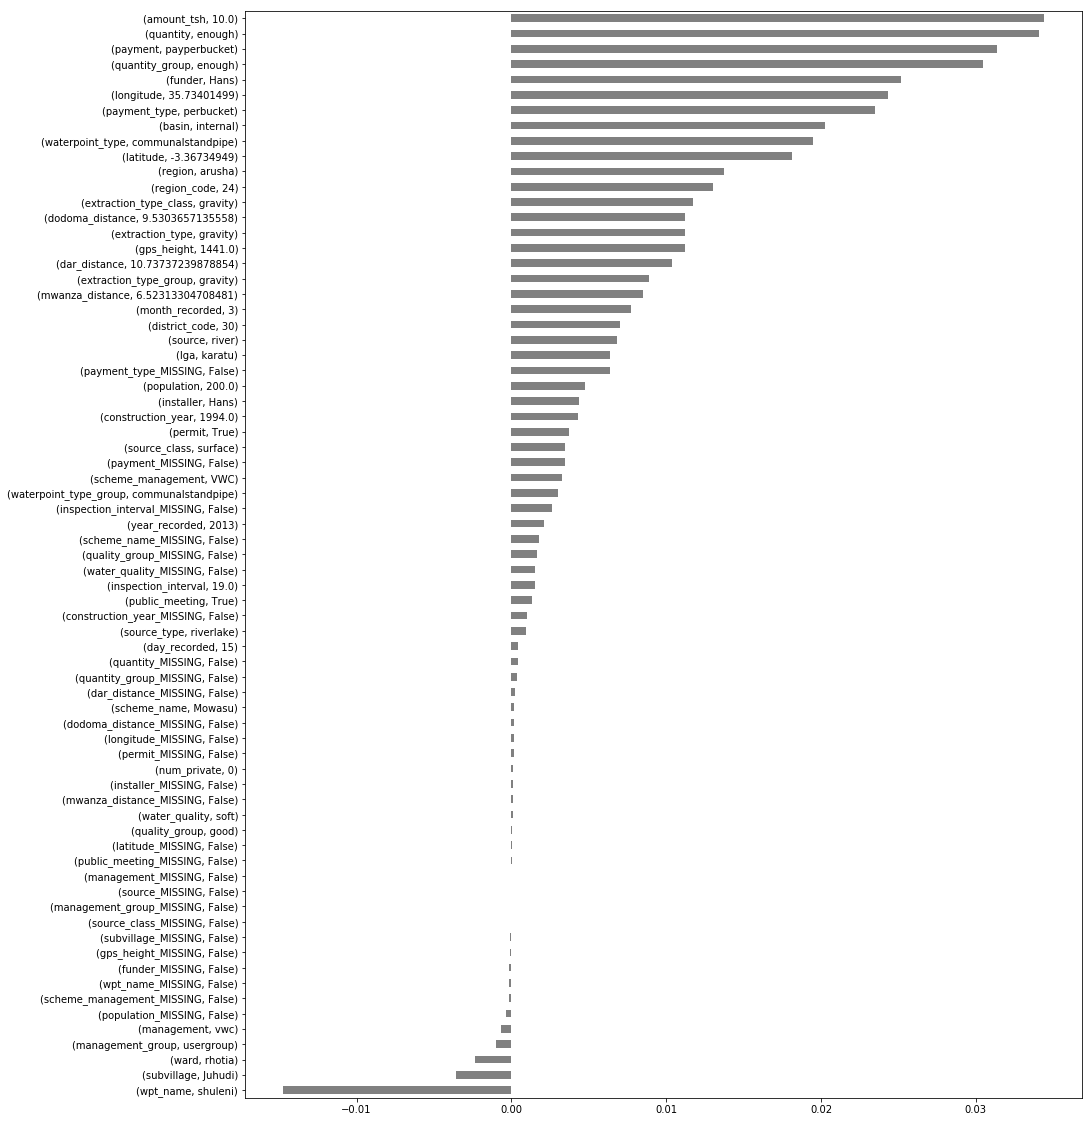

In [15]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0][0], zip(feature_names,feature_values))
shaps.sort_values().plot.barh(color='grey', figsize=(15,20));